In [ ]:
import astropy
import hpgeom as hp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.io import fits
import os
from astropy.table import Table, vstack
import skyproj
import pyproj
import healsparse as hsp
import healpy as hp
import ugali
from __future__ import division
import warnings
from matplotlib.path import Path
from ugali.analysis.isochrone import factory as isochrone_factory
from ugali.utils.shell import get_iso_dir
import hats
import lsdb
from matplotlib.colors import LogNorm
from astropy.table import QTable
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.polynomial import polynomial
from numpy.polynomial.polynomial import polyvander2d
import numpy.ma as ma
import glob
import astropy.io.fits as fitsio
from astropy import table

In [ ]:
#Read in Delve Data
delve_path = "/epyc/data/delve/dr3/delve_dr3_stellar_skim/"
delve_object = lsdb.read_hats(delve_path, columns=["COADD_OBJECT_ID", "RA", "DEC", 'MAG_PSF_SFD_G', 'MAG_PSF_SFD_R'])

In [ ]:
#Read in Des Data
#first file
fileone = 'strange_findings/des_dr2_x_gaia_08131.fits'
hdulone = fits.open(fileone)
hdulone.info()
hdulone[1].columns
data = hdulone[1].data
# get columns
des_ra = data['DES_RA']
des_dec = data['DES_DEC']
gmag = data['DES_WAVG_MAG_PSF_G_DERED']
rmag = data['DES_WAVG_MAG_PSF_R_DERED']
# make table with columns
des = Table([des_ra, des_dec, gmag, rmag],
              names=('RA', 'Dec', 'gmag', 'rmag'))
fits_directory = 'strange_findings'
fits_files = [f for f in os.listdir(fits_directory) if f.endswith('.fits')]
# Read all in
fits_data = []
for fits_file in fits_files:
    with fits.open(os.path.join(fits_directory, fits_file)) as hdul:
        fits_data.append(hdul)
        data = hdul[1].data
        des_ra = data['DES_RA']
        des_dec = data['DES_DEC']
        gmag = data['DES_WAVG_MAG_PSF_G_DERED']
        rmag = data['DES_WAVG_MAG_PSF_R_DERED']
        temp_table = Table([des_ra, des_dec, gmag, rmag], names=('RA', 'Dec', 'gmag', 'rmag'))
        des = vstack([des, temp_table])

Filename: strange_findings/des_dr2_x_gaia_08131.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    106   16386R x 49C   [D, D, K, I, E, E, E, E, E, E, E, E, E, E, E, E, K, 30A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E]   


In [ ]:
des_aau_box = des[(des['RA'] > 10) & (des['RA'] < 40) & (des['Dec'] > -40) & (des['Dec'] < -20) & (des['gmag'] < 23.5) & (des['gmag'] > 16) & (des['gmag'] - des['rmag'] < 1) & (des['gmag'] - des['rmag'] > 0)]

In [ ]:
# Original Define Isochrone Functions
def mkpol(mu, age=12., z=0.0004, dmu=0.5, C=[0.05, 0.05], E=4., clip=True):
    """Make the the isochrone matched-filter polygon.

    Parameters
    ----------
    mu : distance modulus
    age: isochrone age [Gyr]
    z  : isochrone metallicity [Z_sol]
    dmu: distance modulus spread
    C  : additive color spread
    E  : multiplicative error spread
    err: photometric error model; function that returns magerr as 
         a function of magnitude.
    survey: key to load error model
    clip: maximum absolute magnitude
    
    Returns
    -------
    verts : vertices of the polygon
    """
            #warnings.warn('Using DES photometric error model!')
    err=lambda x: 0.0010908679647672335 + np.exp((x - 27.091072029215375) / 1.0904624484538419)
    #err=lambda x: 0.0004 + np.exp((x - 26.8) / 1.2) #Sam's error function
    #print(err)
    #print('i am error')
            #err = surveys.surveys['DES_DR1']['err']
    """ Builds ordered polygon for masking """
    iso = isochrone_factory('Dotter', survey='DES', age=age, distance_modulus=mu, z=z)

    color=iso.color
    mag=iso.mag
    #print(color)
    #print(mag)


    if clip is not None:
        # Clip for plotting, use gmin otherwise
        # clip abs mag
        cut = (mag > clip) & ((mag + mu) < 24) & \
            (color > 0) & (color < 1)
        color = color[cut]
        mag = mag[cut]

    # Spread in magnitude     
    mnear = mag + mu - dmu / 2.
    mfar = mag + mu + dmu / 2.
    #print(mnear)
    #print('hi')
    #print(mfar)
    #print('i am mfar')
    # Spread in color
    C = np.r_[color + E * err(mfar) + C[1], color[::-1] - E * err(mnear[::-1]) - C[0]]
    #print(err(mfar - mu))
    #print(C[0],C[1])
    #print('i am mfrae error')
    M = np.r_[mag, mag[::-1]]
    return np.c_[C, M]


def select_isochrone(mag_g, mag_r, iso_params=[17.0, 12.5, 0.0001], dmu=0.5, C=[0.01, 0.01], E=2, gmin=None):
    #select iso parameters from paper
    #C is width of g-r
    #E multiplies error dw
    #gmin IF cut off RGB, other bright stars
    """Create the isochrone matched-fitler polygon and select stars that
    reside within it.

    Parameters
    ----------
    mag_g, mag_r : measured magnitudes of the stars
    err: photometric error model; function that returns magerr as 
         a function of magnitude.
    iso_params : isochrone parameters [mu, age, Z]
    dmu: distance modulus spread
    C  : additive color spread
    E  : multiplicative error spread
    gmin : bright magnitude limit in g-band
    survey: key to load error model
    
    Returns
    -------
    selection : boolean array indicating if the object is in the polygon

    """
    mu, age, z = iso_params
    
    
    mk = mkpol(mu=mu, age=age, z=z, dmu=dmu, C=C, E=E, clip=None)
    #print(mk)
    pth = Path(mk)
    #print(pth)
    cm = np.vstack([mag_g - mag_r, mag_g - mu]).T
    idx = pth.contains_points(cm)
    if gmin:
        idx &= (mag_g > gmin)
        #mk = mk[mk[:,1] >= gmin]
    return idx #Sam: return mk, idk

## Original Define isochrone functions

In [ ]:
def polyfit2d(x, y, f, deg):
    """
    Fit a 2d polynomial.

    Parameters:
    -----------
    x : array of x values
    y : array of y values
    f : array of function return values
    deg : polynomial degree (length-2 list)

    Returns:
    --------
    c : polynomial coefficients
    """
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = polynomial.polyvander2d(x, y, deg)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

In [ ]:
# Necessary variables
distance_modulus = 16.8
font_properties = {'family': 'serif', 'weight': 'bold', 'size': 14}

In [ ]:
selector = select_isochrone(des_aau_box['gmag'], des_aau_box['rmag'], iso_params=[distance_modulus, 11., 0.0007])
des_aau_iso = des_aau_box[selector]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_20142/2724811112.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


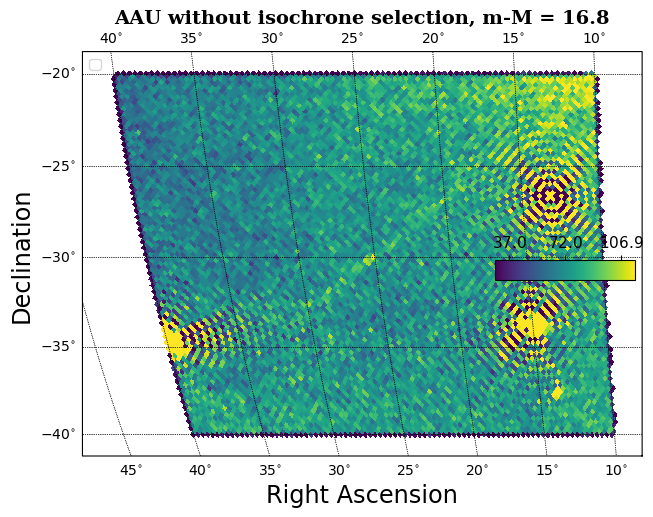

In [ ]:
# Plot withouot modifications
ra = des_aau_box['RA']
dec = des_aau_box['Dec']
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax)
sp.legend()
hpxbin = sp.draw_hpxbin(lon=ra, lat=dec, C=None, nside=256, nest=False, zoom=True, xsize=1000, vmin=None, vmax=None, rasterized=True, lon_range=None, lat_range=None, norm='linear')
sp.draw_hpxmap(hp.smoothing(hpxbin[0], fwhm=np.radians(0.)), cmap=plt.cm.viridis)
plt.title(f'AAU without isochrone selection, m-M = {distance_modulus}', fontdict=font_properties, y=1.05)
sp.draw_inset_colorbar()
plt.tight_layout()
#plt.savefig('name.png')
plt.show()

In [ ]:
#help(sp.draw_hpxbin)

Items to focus on: Make a hpxbin plot with masking and background subtraction. Maybe use spherical harmonics eventually? Look through Gaia for a possible extension to the AAU stream.

In [ ]:
#hpxbin[0]

In [ ]:
#hpxbin[0][3345]

In [ ]:
#hpxbin

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_121873/3699380238.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


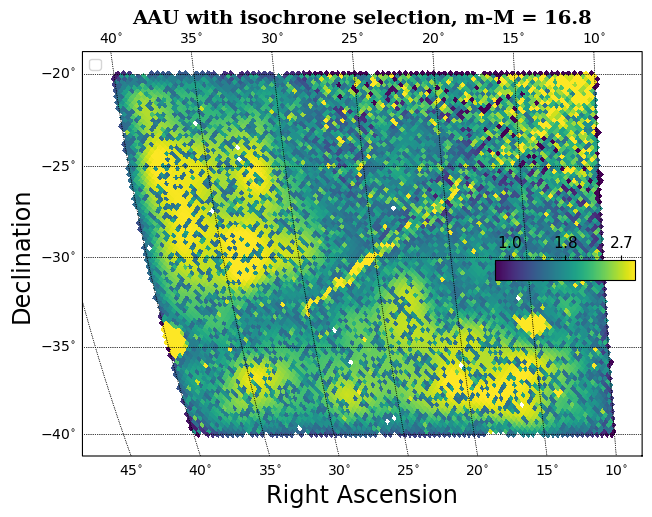

In [ ]:
# Try to plot with a masked array
ra = des_aau_iso['RA']
dec = des_aau_iso['Dec']
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax)
sp.legend()
# Get HEALPix bin counts
hpxbin = sp.draw_hpxbin(ra, dec, nside=256)
hpxbin_counts = hpxbin[0].copy()
# masked array at bin counts > 7... is this correctly implemented???
masked_counts = ma.masked_greater_equal(hpxbin_counts, 7)
# Smoothing (masked values are ignored)
smoothed_map = hp.smoothing(masked_counts.filled(0), fwhm=np.radians(2)) #make masked counts zero and leave everything else unaltered
# Internet says reapply mask after smoothing (since smoothing might leak) ??
smoothed_map_masked = ma.masked_where(masked_counts.mask, smoothed_map)
# Plot
sp.draw_hpxmap(smoothed_map_masked, cmap=plt.cm.viridis)
plt.title(f'AAU with isochrone selection, m-M = {distance_modulus}', fontdict=font_properties, y=1.05)
sp.draw_inset_colorbar()
plt.tight_layout()
#plt.savefig('name.png')
plt.show()

In [ ]:
#smoothed_map_masked

In [ ]:
#print(len(hpxbin_counts))
#print(len(ra))

The following few cells are from last week's approach (clipping and plotting in matplotlib). Try to improve on this by fitting a ploynomial directly to the hp map

In [ ]:
hist, xedges, yedges = np.histogram2d(ra, dec, bins=(50, 50))
hist = np.clip(hist, 0, 500)
# Get the bin centers
x_centers = (xedges[:-1] + xedges[1:]) / 2  # RA bin centers
y_centers = (yedges[:-1] + yedges[1:]) / 2  # Dec bin centers
# Create a grid of bin centers
xx, yy = np.meshgrid(x_centers, y_centers, indexing='ij')
# Flatten the histogram values for `f`
f = hist.flatten()
# Flatten the bin centers for `x` and `y`
x = xx.flatten()
y = yy.flatten()
# Fit a 2D polynomial of degree 5
deg = [5, 5]
coefficients = polyfit2d(x, y, f, deg)
# `coefficients` now contains the polynomial coefficients
#print(coefficients)
poly_values = polynomial.polyval2d(xx, yy, coefficients)

/tmp/ipykernel_121873/1176035818.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [ ]:
#x_centers

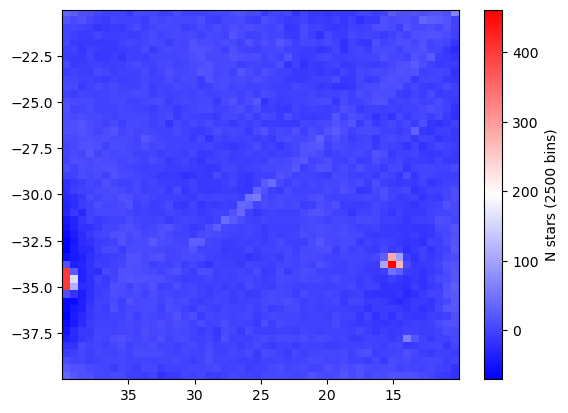

In [ ]:
plt.figure()
plt.imshow((hist-poly_values).T, extent=[xedges[0], xedges[-1], yedges[-1], yedges[0]], cmap=plt.cm.bwr, aspect='auto', origin='upper')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(label='N stars (2500 bins)')

In [ ]:
#hist

^ Faulty approach.

Mask out based on different criteria, point by point.
Don't use skyproj for non-plotting

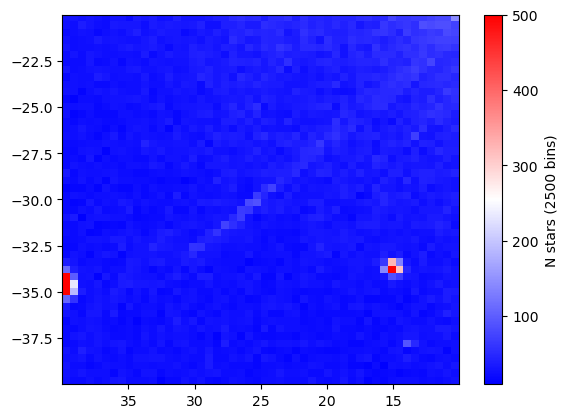

In [ ]:
plt.figure()
plt.imshow((hist).T, extent=[xedges[0], xedges[-1], yedges[-1], yedges[0]], cmap=plt.cm.bwr, aspect='auto', origin='upper')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(label='N stars (2500 bins)')

In [ ]:
#des_aau_box

In [ ]:
pix = hp.ang2pix(512, des_aau_box['RA'], des_aau_box['Dec'], lonlat=True) #gives pixel ids - healpix ids of each object (resolution-dependent)

In [ ]:
#get a list of healpix
upix, counts = np.unique(pix, return_counts=True) #upix is unique pixels

In [ ]:
counts

array([6, 2, 4, ..., 2, 4, 1])

In [ ]:
pix512 = (np.ones(hp.nside2npix(nside=512)) * hp.UNSEEN)

In [ ]:
pix512[upix] = counts

In [ ]:
pix512[upix]

array([6., 2., 4., ..., 2., 4., 1.])

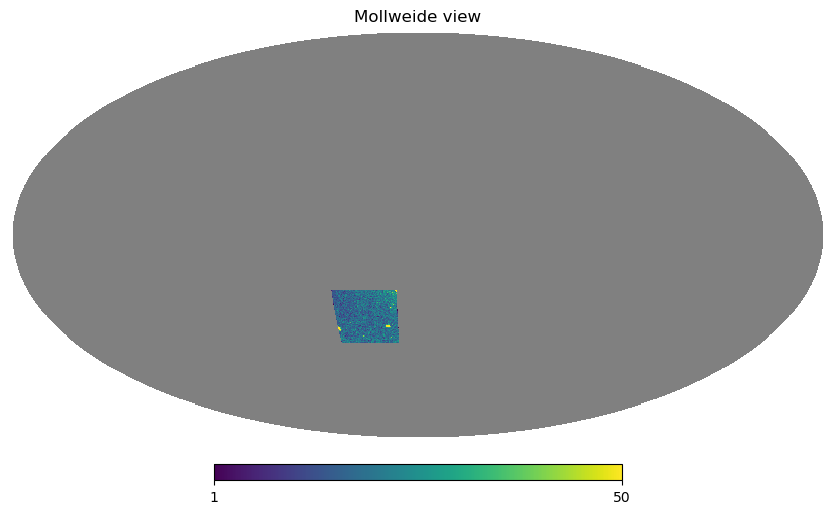

In [ ]:
hp.mollview(pix512, max=50)

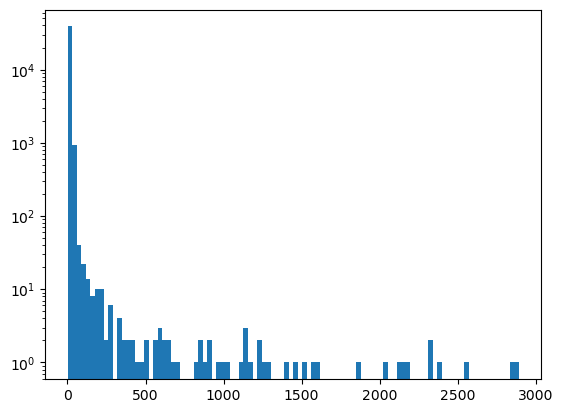

In [ ]:
plt.hist(pix512[~(pix512 == hp.UNSEEN)], bins=100)
plt.yscale('log') #distribution of pixels 
# possibly mask out high bins

In [ ]:
min1, max1 = np.percentile(pix512[~(pix512 == hp.UNSEEN)], [5,95])

In [ ]:
pix512

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

In [ ]:
mask_sel = (pix512 == hp.UNSEEN) | (pix512 < min1 -1) | (pix512 > max1)
masked_array = np.ma.array(pix512, mask=mask_sel, fill_value=hp.UNSEEN) # fill vals are only relevant when they are: usually just ignored. could be nan

/tmp/ipykernel_20142/4166831516.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


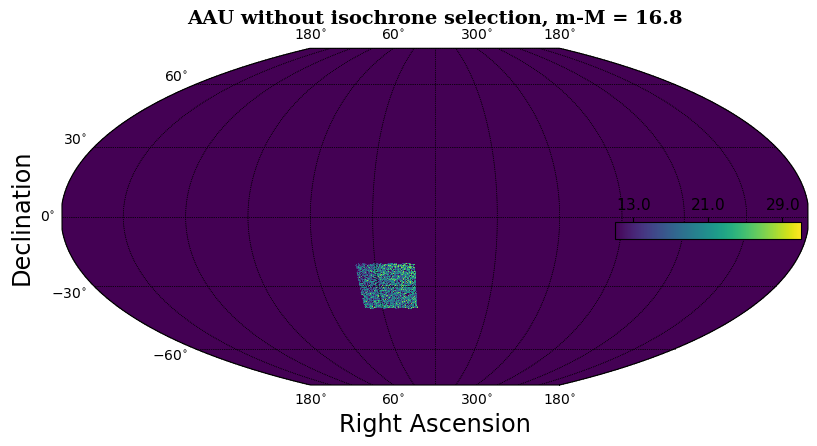

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax)
# Get HEALPix bin counts
vmin, vmax = np.percentile(pix512[~(pix512 == hp.UNSEEN)], [5,98])
sp.draw_hpxmap(masked_array.filled(0), cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
plt.title(f'AAU without isochrone selection, m-M = {distance_modulus}', fontdict=font_properties, y=1.05)
sp.draw_inset_colorbar()
plt.tight_layout()
#plt.savefig('name.png')
plt.show()

/tmp/ipykernel_20142/2358148608.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


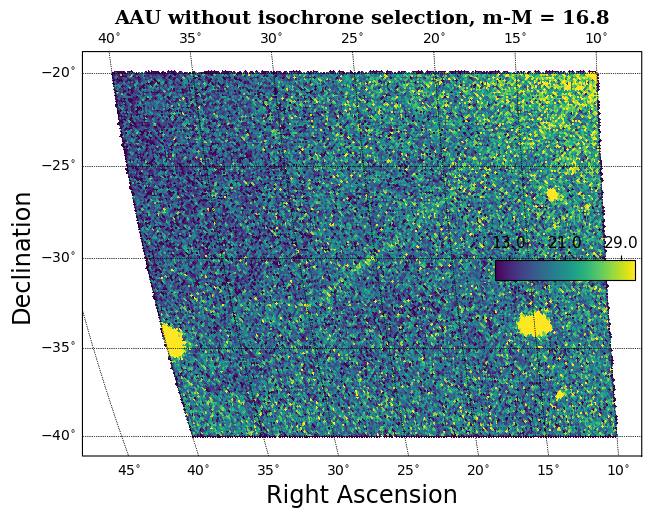

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.McBrydeSkyproj(ax=ax)
# Get HEALPix bin counts
sp.draw_hpxmap(pix512, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
plt.title(f'AAU without isochrone selection, m-M = {distance_modulus}', fontdict=font_properties, y=1.05)
sp.draw_inset_colorbar()
plt.tight_layout()
#plt.savefig('name.png')
plt.show()

In [ ]:
#masked_array

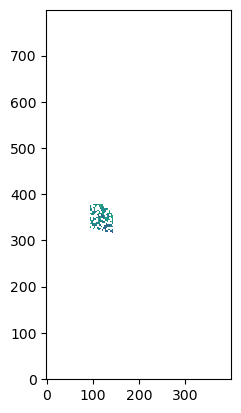

In [ ]:
def func_vec2pix(nside):
    return lambda x, y, z: hp.vec2pix(nside, x, y, z)


vec2pix = func_vec2pix(nside=512)

proj=hp.projector.MollweideProj()
img=proj.projmap(masked_array.filled(np.nan), vec2pix) 
plt.imshow(img.T, origin="lower")

In [ ]:
#hp.vec2pix?

In [ ]:
#use pix2ang to get Ra vals, Dec vals.

In [ ]:
newfittest = np.polyfit(x=np.arange(start=0,stop=len(counts)), y=counts, deg=8)

In [ ]:
newfittest

array([-3.14070402e-33,  4.56146241e-28, -2.66154397e-23,  8.00285790e-19,
       -1.32269936e-14,  1.18591534e-10, -5.27229545e-07,  8.73239687e-04,
        2.45787011e+00])

In [ ]:
len(newfittest)

9

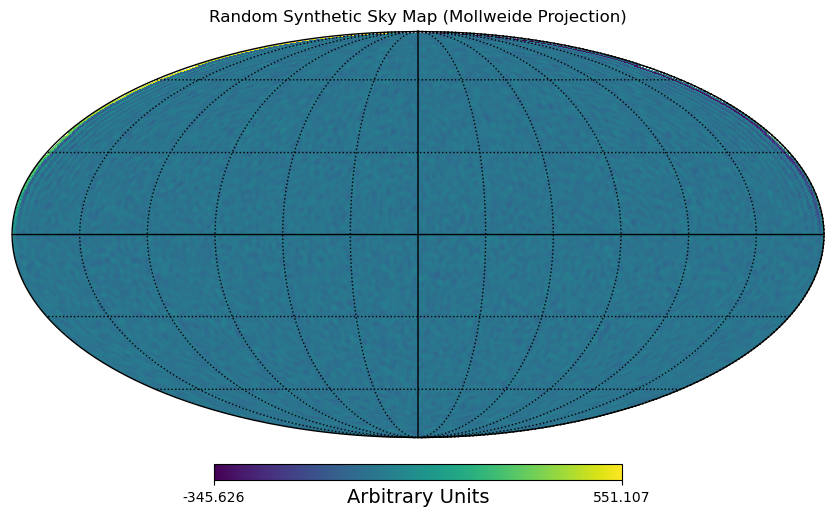

In [ ]:
# Generate random alm coefficients (for illustration)
lmax = 128
alm = np.random.rand(hp.Alm.getsize(lmax)) + 1j * np.random.rand(hp.Alm.getsize(lmax))

# Synthesize a map from alm
nside = 64

#CRUCIALLY: ALM IS CONVERTED TO MAP FORM HERE:

sky_map = hp.alm2map(alm, nside=nside)
hp.mollview(sky_map, title="Random Synthetic Sky Map (Mollweide Projection)", 
            unit="Arbitrary Units", cmap="viridis")
hp.graticule()  # Add grid lines (optional)
plt.show()
# Now, sky_map is a Healpix map (np array of size 12 * nside^2)

#Now, instead of generating random alm, fit some alm to the hp masked array.

In [ ]:
sky_map

array([107.14641965, 387.79979149,  68.95201135, ...,   7.55680837,
       -12.74337404, -12.9751659 ])

In [ ]:
masked_array

NameError: name 'masked_array' is not defined

In [ ]:
alm_original = hp.map2alm(masked_array, lmax)

In [ ]:
hp.map2alm?


Signature:
hp.map2alm(
    maps,
    lmax=None,
    mmax=None,
    iter=3,
    pol=True,
    use_weights=False,
    datapath=None,
    gal_cut=0,
    use_pixel_weights=False,
    verbose=True,
)
Docstring:
Computes the alm of a Healpix map. The input maps must all be
in ring ordering.

For recommendations about how to set `lmax`, `iter`, and weights, see the
`Anafast documentation <https://healpix.sourceforge.io/html/fac_anafast.htm>`_

Pixel values are weighted before applying the transform:

* when you don't specify any weights, the uniform weight value 4*pi/n_pix is used
* with ring weights enabled (use_weights=True), pixels in every ring
  are weighted with a uniform value similar to the one above, ring weights are
  included in healpy
* with pixel weights (use_pixel_weights=True), every pixel gets an individual weight

Pixel weights provide the most accurate transform, so you should always use them if
possible. However they are not included in healpy and will be automatically down

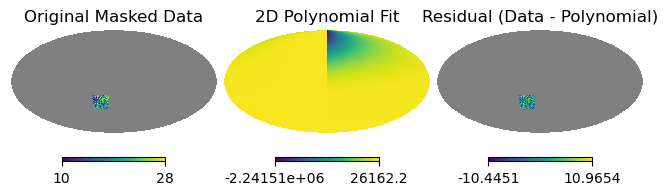

In [ ]:
nside = 512
npix = hp.nside2npix(nside)
alm_original = hp.map2alm(masked_array)



good_pixels = np.where(~masked_array.mask)[0]
theta, phi = hp.pix2ang(nside, good_pixels)

# Use cosθ instead of θ (better for polynomial fitting)
cos_theta = np.cos(theta)
phi_norm = phi / np.pi  # Normalize φ to [-1, 1]

# Define polynomial degree (e.g., 3rd order)
degree = 3

# Construct Vandermonde matrix for 2D polynomial fitting
x, y = cos_theta, phi_norm
vander = polyvander2d(x, y, [degree, degree])

# Perform least-squares fit (ignoring masked data)
coeffs, _, _, _ = np.linalg.lstsq(vander, masked_array[good_pixels], rcond=None)

# Evaluate polynomial across ALL pixels
theta_all, phi_all = hp.pix2ang(nside, np.arange(npix))
cos_theta_all = np.cos(theta_all)
phi_norm_all = phi_all / np.pi

# Evaluate polynomial model on all pixels
vander_all = polyvander2d(cos_theta_all, phi_norm_all, [degree, degree])
poly_model = np.dot(vander_all, coeffs)

# Subtract polynomial and compute new alm
residual_data = masked_array.copy()
residual_data[~masked_array.mask] -= (1 * poly_model[~masked_array.mask]) #Take out the .5

# Get residual alm
alm_residual = hp.map2alm(residual_data)
#not necessary.




hp.mollview(masked_array, title="Original Masked Data", sub=(1, 3, 1))
hp.mollview(poly_model, title="2D Polynomial Fit", sub=(1, 3, 2))
hp.mollview(residual_data, title="Residual (Data - Polynomial)", sub=(1, 3, 3))
plt.show()

In [ ]:
poly_model

masked_array(data=[ 6.59661662e+02, -5.10789476e+04, -4.26035529e+05, ...,
                    3.56538632e+02,  4.50475674e+03,  1.66032543e+04],
             mask=False,
       fill_value=-1.6375e+30)

/tmp/ipykernel_20142/136550953.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/astro/users/scharney/.conda/envs/stream-search/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/tmp/ipykernel_20142/1546771912.py:9: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  smoothed = hp.smoothing(data, sigma=np.radians(sigma), verbose=False)
/tmp/ipykernel_20142/1176035818.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]
/astro/users/scharney/.conda/envs/stream-searc

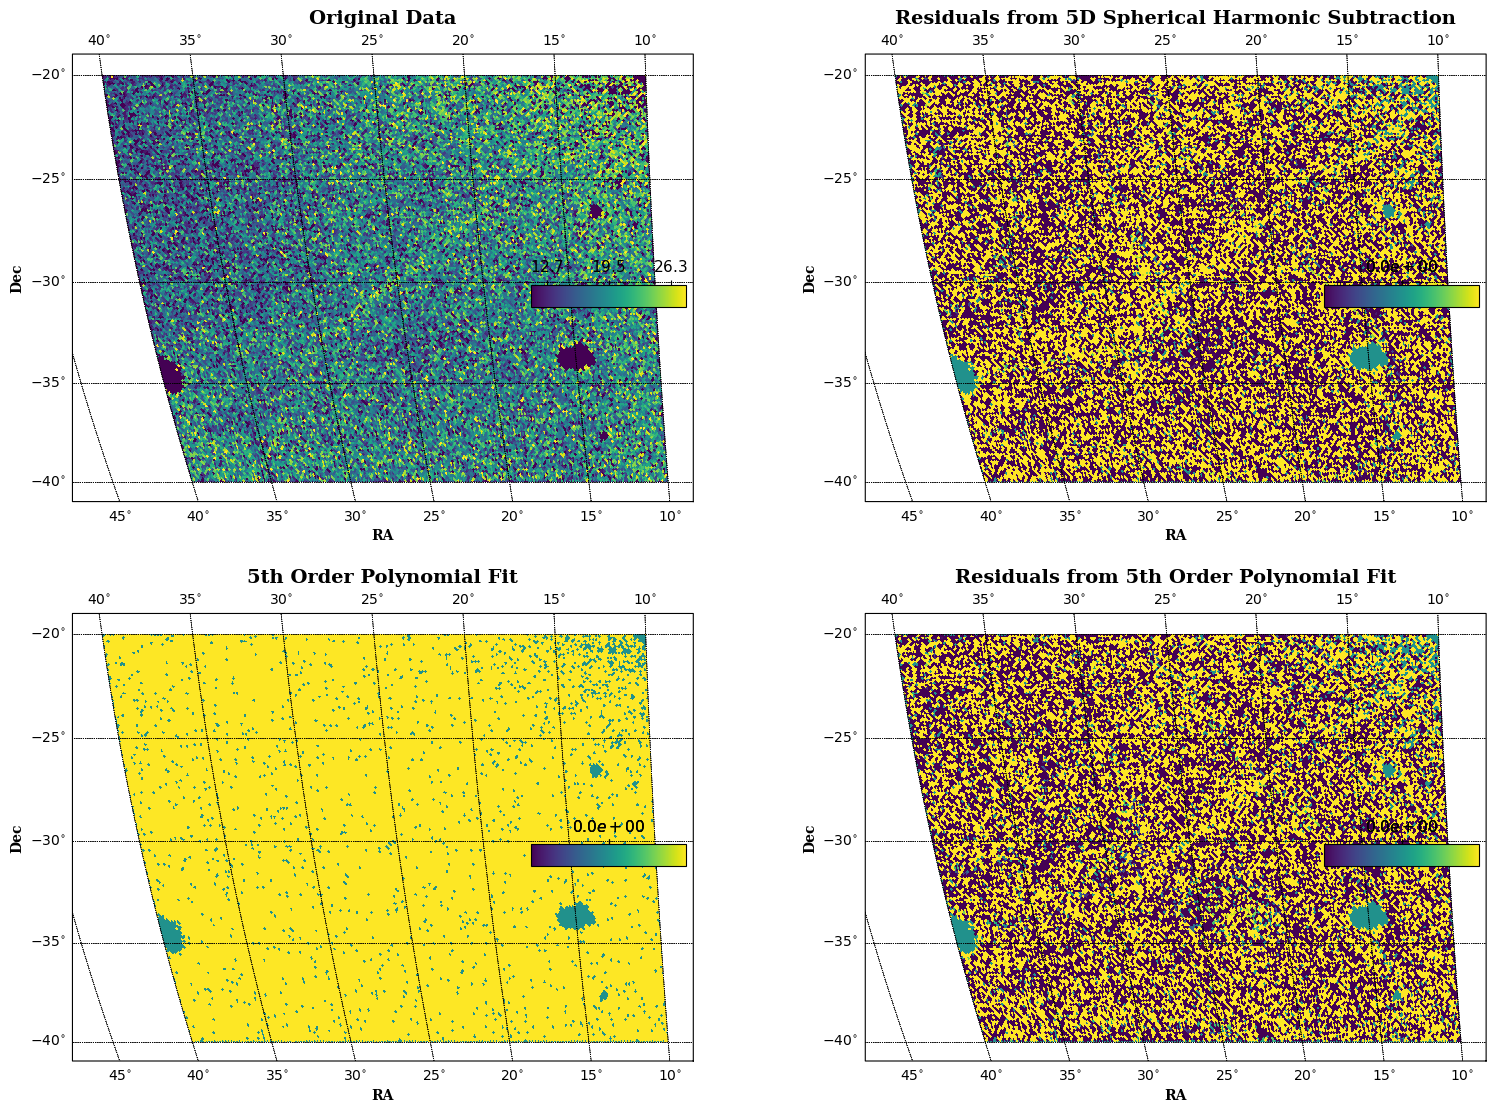

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11))

font_properties = {'family': 'serif', 'weight': 'bold', 'size': 14}

sp = skyproj.McBrydeSkyproj(ax=ax1)
vmin, vmax = np.percentile(pix512[~(pix512 == hp.UNSEEN)], [5,95])
#smooth = hp.smoothing(masked_array, np.radians(0.3))
thing1 = sp.draw_hpxmap(masked_array.filled(0), cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, lon_range=[10,40], lat_range=[-40,-20]) # use smooth in place of masked array if reverting
sp.ax.set_title(f'Original Data', fontdict=font_properties, y=1.05)
sp.ax.set_xlabel('RA', fontsize=10, fontdict=font_properties)
sp.ax.set_ylabel('Dec', fontsize=10, fontdict=font_properties)
sp.draw_inset_colorbar()
plt.tight_layout()

sp = skyproj.McBrydeSkyproj(ax=ax2)
vmin, vmax = np.percentile(residual_data, [5,95])
thing2 = sp.draw_hpxmap(residual_data.filled(0), cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, lon_range=[10,40], lat_range=[-40,-20])
sp.ax.set_title(f'Residuals from 5D Spherical Harmonic Subtraction', fontdict=font_properties, y=1.05)
sp.ax.set_xlabel('RA', fontsize=10, fontdict=font_properties)
sp.ax.set_ylabel('Dec', fontsize=10, fontdict=font_properties)
sp.draw_inset_colorbar()

sp = skyproj.McBrydeSkyproj(ax=ax3)
bkg = fit_bkg(masked_array, proj=proj, sigma=0, percent=[2, 95], deg=5)
vmin, vmax = np.percentile(bkg, [5,95])
thing3 = sp.draw_hpxmap(bkg.filled(0), cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, lon_range=[10,40], lat_range=[-40,-20])
sp.ax.set_title(f'5th Order Polynomial Fit', fontdict=font_properties, y=1.05)
sp.ax.set_xlabel('RA', fontsize=10, fontdict=font_properties)
sp.ax.set_ylabel('Dec', fontsize=10, fontdict=font_properties)
sp.draw_inset_colorbar()

sp = skyproj.McBrydeSkyproj(ax=ax4)
residualz = masked_array - bkg
vmin, vmax = np.percentile(residualz, [5,95])
thing4 = sp.draw_hpxmap(residualz.filled(0), cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, lon_range=[10,40], lat_range=[-40,-20])
sp.ax.set_title(f'Residuals from 5th Order Polynomial Fit', fontdict=font_properties, y=1.05)
sp.ax.set_xlabel('RA', fontsize=10, fontdict=font_properties)
sp.ax.set_ylabel('Dec', fontsize=10, fontdict=font_properties)
sp.draw_inset_colorbar()

plt.subplots_adjust(wspace=0.25, hspace=0.25)

#plt.savefig('subtraction_types.png')
plt.show()

In [ ]:
hp.mollview?

In [ ]:
bkg = fit_bkg(masked_array, proj=proj)

/tmp/ipykernel_20142/1546771912.py:9: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  smoothed = hp.smoothing(data, sigma=np.radians(sigma), verbose=False)
/tmp/ipykernel_20142/1176035818.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [ ]:
len(bkg)

3145728

In [ ]:
proj = hp.projector.MollweideProj()

In [ ]:
def fit_bkg(data, proj, sigma=0.1, percent=[2, 95], deg=5):
    nside = hp.get_nside(data.mask)
    lon, lat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)

    vmin, vmax = np.percentile(data.compressed(), q=percent)
    data = np.clip(data, vmin, vmax)
    data.fill_value = np.ma.median(data)

    smoothed = hp.smoothing(data, sigma=np.radians(sigma), verbose=False)
    data = np.ma.array(smoothed, mask=data.mask)

    sel = ~data.mask
    x, y = proj.ang2xy(lon[sel], lat[sel], lonlat=True)

    xmin, xmax, ymin, ymax = proj.get_extent()
    sel2 = (x > xmin) & (x < xmax) & (y > ymin) & (y < ymax)
    # sel2 = ~np.isnan(x) & ~np.isnan(y)

    v = data[sel][sel2]
    x = x[sel2]
    y = y[sel2]

    c = polyfit2d(x, y, v, [deg, deg])

    # Evaluate the polynomial
    x, y = proj.ang2xy(lon, lat, lonlat=True)
    bkg = polynomial.polyval2d(x, y, c)
    bkg = np.ma.array(bkg, mask=data.mask, fill_value=np.nan)

    return bkg


In [ ]:
def prepare_data(hpxmap, fracdet, fracmin=FRACMIN, clip=None, degrade=None, mask_kw=dict()):
    nside = hp.get_nside(hpxmap)
    mask = (fracdet < fracmin) | (hpxmap > np.percentile(hpxmap, clip)) | make_mask(nside, **mask_kw)
    data = np.ma.array(hpxmap, mask=mask, fill_value=np.nan)
    data /= fracdet
    return data

def prepare_hpxmap(mu, hpxcube, fracdet, modulus, fracmin=0.5, clip=100, sigma=0.2, **mask_kw):
    # fracdet = np.ones(hpxmap.size)
    # fracdet[hpxmap == hp.UNSEEN] = 0

    i = np.argmin(np.abs(mu - modulus))
    hpxmap = np.copy(hpxcube[:, i])

    data = prepare_data(
        hpxmap, fracdet, fracmin=fracmin, clip=clip, mask_kw=mask_kw)
    # bkg = streamlib.fit_bkg_poly(data, sigma=sigma)
    # bkg = None
    return data


NameError: name 'FRACMIN' is not defined

In [ ]:
bkg_poly = fit_bkg_poly(masked_array)

/tmp/ipykernel_107397/4000426608.py:9: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  data = np.ma.array(hp.smoothing(data, sigma=np.radians(sigma), verbose=False),


RuntimeError: Must specify a projection.

In [ ]:
skyproj.McBrydeSkyproj?


Init signature:
skyproj.McBrydeSkyproj(
    ax=None,
    *,
    lon_0=0.0,
    gridlines=True,
    celestial=True,
    extent=None,
    longitude_ticks='positive',
    autorescale=True,
    galactic=False,
    rcparams={},
    n_grid_lon=None,
    n_grid_lat=None,
    min_lon_ticklabel_delta=0.1,
    **kwargs,
)
Docstring:     
A McBryde-Thomas Flat Polar Quartic projection Skyproj map.

Parameters
----------
ax : `matplotlib.axes.Axes`, optional
    Axis object to replace with a skyproj axis.
lon_0 : `float`, optional
    Central longitude of projection.
gridlines : `bool`, optional
    Draw gridlines?
celestial : `bool`, optional
    Do celestial plotting (e.g. invert longitude axis).
extent : iterable, optional
    Default exent of the map, [lon_min, lon_max, lat_min, lat_max].
    Note that lon_min, lon_max can be specified in any order, the
    orientation of the map is set by ``celestial``.
longitude_ticks : `str`, optional
    Label longitude ticks from 0 to 360 degrees (``posit

In [ ]:
delve_object.compute()

KeyboardInterrupt: 

In [ ]:
delve_pix = hp.ang2pix(512, delve_object['RA'], delve_object['DEC'], lonlat=True) #gives pixel ids - healpix ids of each object (resolution-dependent)
#get a list of healpix
unique_delve_pix, delve_bin_counts = np.unique(pix, return_counts=True) #upix is unique pixels
pix_in_map = (np.ones(hp.nside2npix(nside=512)) * hp.UNSEEN)
pix_in_map[unique_delve_pix] = delve_bin_counts

#plt.hist(pix_in_map[~(pix_in_map == hp.UNSEEN)], bins=100)
#plt.yscale('log') #distribution of pixels 
# possibly mask out high bins

mask_sel = (pix_in_map == hp.UNSEEN) #| (pix512 < min1 -1) | (pix512 > max1)
masked_delve_array = np.ma.array(pix_in_map, mask=mask_sel, fill_value=hp.UNSEEN) # fill vals are only relevant when they are: usually just ignored. could be nan

/tmp/ipykernel_121873/45588806.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


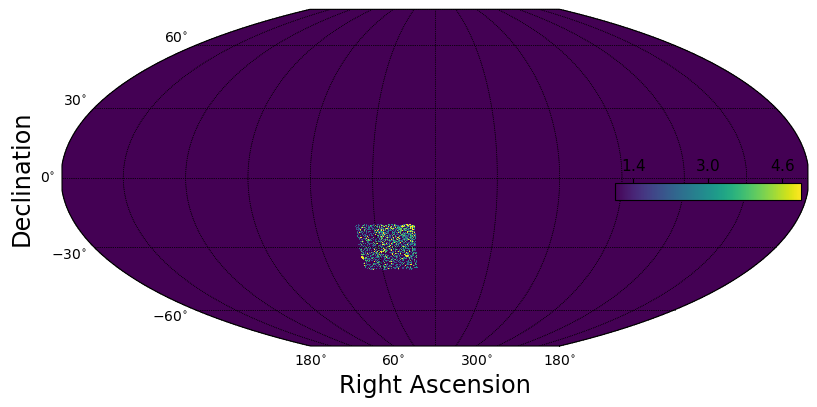

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sp = skyproj.McBrydeSkyproj(ax=ax)
# Get HEALPix bin counts
vmin, vmax = np.percentile(pix_in_map[~(pix_in_map == hp.UNSEEN)], [5,95])
#smooth = hp.smoothing(masked_array, np.radians(0.3))
thing = sp.draw_hpxmap(masked_delve_array.filled(0), cmap=plt.cm.viridis, vmin=vmin, vmax=vmax) #,lon_range=[10,40], lat_range=[-40,-20]) # use smooth in place of masked array if reverting
ax.set_title(f'Pre-subtraction', fontdict=font_properties, y=1.05)
sp.draw_inset_colorbar()
plt.tight_layout()

AttributeError: 'Catalog' object has no attribute 'size'

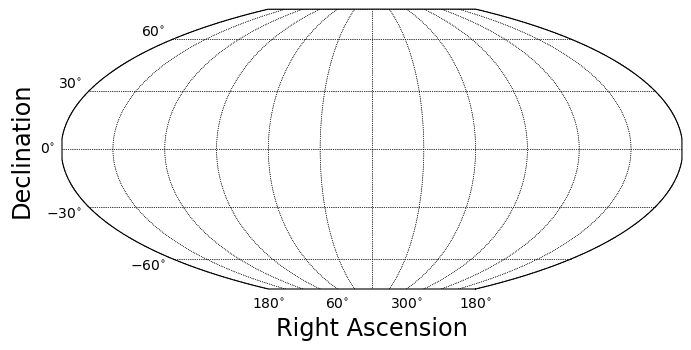

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sp = skyproj.McBrydeSkyproj(ax=ax)
thing = sp.draw_hpxmap(delve_object, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax) #,lon_range=[10,40], lat_range=[-40,-20]) # use smooth in place of masked array if reverting
ax.set_title(f'Pre-subtraction', fontdict=font_properties, y=1.05)
sp.draw_inset_colorbar()
plt.tight_layout()

In [ ]:
# Start making the Delve DR3 Movie

delve = delve_object[(1 > (delve_object['MAG_PSF_SFD_G'] - delve_object['MAG_PSF_SFD_R'])) & (0 < (delve_object['MAG_PSF_SFD_G'] - delve_object['MAG_PSF_SFD_R'])) & (delve_object['MAG_PSF_SFD_G'] < 23.5) & (delve_object['MAG_PSF_SFD_G'] > 19)]

In [ ]:
len(delve)

574775030

In [ ]:
len(delve_object)

574775030

In [ ]:
delve = delve.compute()

In [ ]:
def movie_maker(data, mu_start=15, mu_end=18, mu_step=0.5, save=False, show=True, age=11., z=0.0007, smoothing=0, title='Delve'):
    arange = np.arange(mu_start, mu_end + mu_step, mu_step)
    for mu in arange:
        selector = select_isochrone(data['MAG_PSF_SFD_G'], data['MAG_PSF_SFD_R'], iso_params=[mu, age, z])
        iso_selection = data[selector]
        
        print('0')
        
        # RA/Dec plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        ra = iso_selection['RA']
        dec = iso_selection['DEC']
        sp = skyproj.McBrydeSkyproj(ax=ax1)
        sp.legend()
        hpxbin = sp.draw_hpxbin(ra, dec, nside=512)
        sp.draw_hpxmap(hp.smoothing(hpxbin[0], fwhm=np.radians(smoothing)))
        ax1.set_title('SMC Spatial Plot', fontsize=14)
        
        #Color/Magnitude Plot
        box = mkpol(mu=mu, age=age, z=z, dmu=0.5, C=[0.04, 0.04], E=4., clip=0)
        hist = ax2.hist2d(
            (data['MAG_PSF_SFD_G'] - data['MAG_PSF_SFD_R']),
            data['MAG_PSF_SFD_G'],
            bins=(100, 100),
            cmap=plt.cm.viridis
        )
        ax2.set_title(f'{title}, m-M = {mu:.1f}', fontsize=14)
        ax2.set_xlabel('g-r', fontsize=12)
        ax2.set_ylabel('g', fontsize=12)
        ax2.invert_yaxis()
        
        print('1')

        cbar = plt.colorbar(hist[3], ax=ax2)
        cbar.set_label('N stars (10000 bins)', fontsize=12)
        x, y = zip(*box)
        x = list(x) + [x[0]]  # Close the polygon
        y = list(y) + [y[0]]
        ax2.plot(x, y, marker=None, markersize=20, color='red')
        ax2.fill(x, y, color='lightblue', alpha=0.2)
        
        plt.tight_layout()
        if save:
            plt.savefig(f'{mu}_slice.png', dpi=300, bbox_inches='tight')
        if show:
            plt.show()
            
        print('2')

In [ ]:
delve['MAG_PSF_SFD_G']

Dask Series Structure:
npartitions=1284
0                      double[pyarrow]
4503599627370496                   ...
                            ...       
3457638613913698304                ...
3458764513820540928                ...
Dask Name: getitem, 15 expressions
Expr=(Filter(frame=MapPartitions(NestedFrame), predicate=MapPartitions(NestedFrame)['MAG_PSF_SFD_G'] - MapPartitions(NestedFrame)['MAG_PSF_SFD_R'] < 1 & MapPartitions(NestedFrame)['MAG_PSF_SFD_G'] - MapPartitions(NestedFrame)['MAG_PSF_SFD_R'] > 0 & MapPartitions(NestedFrame)['MAG_PSF_SFD_G'] < 23.5 & MapPartitions(NestedFrame)['MAG_PSF_SFD_G'] > 22))['MAG_PSF_SFD_G']

In [ ]:
movie_maker(data=delve, mu_start=15, mu_end=16, mu_step=0.5, save=True, show=True, age=11., z=0.0007, smoothing=0)

Select cutouts for local saving (isochrone and other)

In [ ]:
#Stream Data
stream_dists = {'Tucana III': 25.1,
                'ATLAS': 22.9,
                'Phoenix': 19.1,
                'Indus': 16.6,
                'Jhelum': 13.2,
                'Chenab': 39.8,
                'Elqui': 50.1,
                'Aliqa Uma': 28.8,
                'Turranburra': 27.5,
                '300S':18,
                'Ravi':22.9,
                'Herc':132}

stream_rvs = {'ATLAS': -99.8,
              'Phoenix': 47.9,
              'Indus': -47.2,
              'Jhelum': (0.20, -34.0),
              'Chenab': -145.5,
              'Elqui': -33.9,
              'Aliqa Uma': -34.0,
              'Ravi':0.,
              'Herc':46.81}


stream_masses = {'Tucana III': 2e-7,
                 'ATLAS': 2e-6,
                 'Phoenix': 2e-6,
                 'Indus': 0.001,
                 'Jhelum': 0.002,
                 'Chenab': 0.001,
                 'Elqui': 0.0001,
                 'Aliqa Uma': 2e-6,
                 'Turranburra': 0.0001,
                 '300S':2e-6,
                 'Ravi':0.0001,
                 'Herc':2e-6}

stream_sigmas = {'Tucana III': 0.05,
                 'ATLAS': 0.01,
                 'Phoenix': 0.01,
                 'Indus': 0.1,
                 'Jhelum': 0.1,
                 'Chenab': 0.5,
                 'Elqui': 0.1,
                 'Aliqa Uma': 0.01,
                 'Turranburra': 0.1,
                 '300S':0.01,
                 'Ravi':0.01,
                 'Herc':0.01}


stream_matrices = {'Aliqa Uma': [[0.66315359, 0.48119409, -0.57330582], [0.74585903, -0.36075668, 0.5599544], [-0.06262284, 0.79894109, 0.59814004]],
                   'ATLAS': [[0.83697865, 0.29481904, -0.4610298], [0.51616778, -0.70514011, 0.4861566], [0.18176238, 0.64487142, 0.74236331]],
                   'Chenab': [[0.51883185, -0.34132444, -0.78378003], [-0.81981696, 0.06121342, -0.56934442], [-0.24230902, -0.93795018, 0.2480641]],
                   'Elqui': [[0.74099526, 0.20483425, -0.63950681], [0.57756858, -0.68021616, 0.45135409], [0.34255009, 0.70381028, 0.62234278]],
                   'Indus': [[0.47348784, -0.22057954, -0.85273321], [0.25151201, -0.89396596, 0.37089969], [0.84412734, 0.39008914, 0.3678036]],
                   'Jhelum': [[0.60334991, -0.20211605, -0.7714389], [-0.13408072, -0.97928924, 0.15170675], [0.78612419, -0.01190283, 0.61795395]],
                   'Phoenix': [[0.5964467, 0.27151332, -0.75533559], [-0.48595429, -0.62682316, -0.60904938], [0.63882686, -0.73032406, 0.24192354]],
                   'Tucana III': [[0.505715, -0.007435, -0.862668], [-0.078639, -0.996197, -0.037514], [0.859109, -0.086811, 0.504377]],
                   'Turranburra': [[0.36111266, 0.85114984, -0.38097455], [0.87227667, -0.16384562, 0.46074725], [-0.32974393, 0.49869687, 0.80160487]],
                   'Jet': [[-0.69798645,  0.61127501, -0.37303856], [-0.62615889, -0.26819784,  0.73211677], [0.34747655,  0.744589,  0.56995374]],
                   '300S': [[-0.88197819,  0.38428506,  0.27283596], [ 0.43304104,  0.88924457,  0.14737555], [-0.18598367,  0.24813119, -0.95070552]],
                   'Ravi': [[0.57336113, -0.22475898, -0.78787081], [0.57203155, -0.57862539, 0.58135407], [0.58654661, 0.78401279, 0.20319208]],
                   'Herc': [[-0.36919252, -0.90261961,  0.22130235], [-0.75419217,  0.43013129,  0.49616655], [-0.54303872,  0.01627647, -0.8395499 ]]}

stream_lengths = {'Aliqa Uma': 10.0,
                  'ATLAS': 22.6,
                  'Chenab': 18.5,
                  'Elqui': 9.4,
                  'Indus': 20.3,
                  'Jhelum': 29.2,
                  'Phoenix': 13.6,
                  'Tucana III': 4.8,
                  'Turranburra': 16.9,
                  'Jet':20.0,
                  '300S':17.0,
                  'Ravi':60.,
                  'Herc':1.}

stream_widths = {'Aliqa Uma': 0.26,
                 'ATLAS': 0.24,
                 'Chenab': 0.71,
                 'Elqui': 0.54,
                 'Indus': 0.83,
                 'Jhelum': 1.16,
                 'Phoenix': 0.16,
                 'Tucana III': 0.18,
                 'Turranburra': 0.60,
                 'Jet':0.2,
                 '300S':0.47,
                 'Ravi':0.72,
                 'Herc':6.3/60.}

stream_vrs = {'Aliqa Uma': 0,
              'ATLAS': 0,
              'Chenab': -150,
              'Elqui': 0,
              'Indus': 0,
              'Jhelum': 0,
              'Phoenix': 0,
              'Tucana III': 0,
              'Turranburra': 0,
              'Jet':272.5,
              '300S':300,
              'Ravi': 0,
              'Herc':46.81}

stream_vr_widths = {'Aliqa Uma': 0,
                    'ATLAS': 0,
                    'Chenab': 4.32,
                    'Elqui': 8.40,
                    'Indus': 5.76,
                    'Jhelum': 13.30,
                    'Phoenix': 0,
                    'Tucana III': 0,
                    'Turranburra': 0,
                    'Jet':0,
                    '300S':0,
                    'Ravi':0,
                    'Herc':0}

stream_phi2s = {'Aliqa Uma': 0,
                'ATLAS': 0.66,
                'Chenab': 0,
                'Elqui': 0,
                'Indus': 0,
                'Jhelum': 0,
                'Phoenix': 0,
                'Tucana III': 0,
                'Turranburra': 0,
                'Jet':0,
                '300S':0,
                'Ravi':0,
                'Herc':0}

stream_mids = {'Aliqa Uma': (35.96519575304428, -34.98107408877647),
               'ATLAS': (19.40440473586367, -27.453578354852883),
               'Chenab': (-33.339759611694205, -51.60798647784715),
               'Elqui': (15.452462557149355, -39.75505320589948),
               'Indus': (-24.978978038471325, -58.510205017947726),
               'Jhelum': (-18.520322938617255, -50.483277585344595),
               'Phoenix': (24.475886399510763, -49.054701430221975),
               'Tucana III': (-1.4880868099542681, -59.641037041735935),
               'Turranburra': (67.01021150038846, -22.394061648029155),}

stream_phi12_pms = {'Aliqa Uma': {'pm1': 0.9803, 'e_pm1': 0.0350, 'pm2': -0.3416, 'e_pm2': 0.0277, 'grad_pm1': -0.0224, 'e_grad_pm1': 0.0209, 'grad_pm2': -0.0362, 'e_grad_pm2': 0.0212},
                    'ATLAS': {'pm1': 1.6602, 'e_pm1': 0.0428, 'pm2': -0.1537, 'e_pm2': 0.0351, 'grad_pm1': 0.0155, 'e_grad_pm1': 0.0049, 'grad_pm2': -0.0179, 'e_grad_pm2': 0.0044},
                    'Chenab': {'pm1': 1.0336, 'e_pm1': 0.0454, 'pm2': -0.5975, 'e_pm2': 0.0287, 'grad_pm1': 0.0440, 'e_grad_pm1': 0.0130, 'grad_pm2': -0.0213, 'e_grad_pm2': 0.0084},
                    'Elqui': {'pm1': 0.5584, 'e_pm1': 0.0606, 'pm2': -0.0280, 'e_pm2': 0.0491, 'grad_pm1': -0.0270, 'e_grad_pm1': 0.0199, 'grad_pm2': -0.0433, 'e_grad_pm2': 0.0141},
                    'Indus': {'pm1': -3.0886, 'e_pm1': 0.0319, 'pm2': 0.2053, 'e_pm2': 0.0285, 'grad_pm1': 0.0542, 'e_grad_pm1': 0.0043, 'grad_pm2': 0.0436, 'e_grad_pm2': 0.0041},
                    # 'Jhelum': {'pm1': -5.9330, 'e_pm1': 0.9163, 'pm2': -0.7612, 'e_pm2': 0.7987, 'grad_pm1': 0.0258, 'e_grad_pm1': 0.1969, 'grad_pm2': 0.0347, 'e_grad_pm2': 0.1505},
                    'Jhelum': {'pm1': -5.9330, 'e_pm1': 0.03, 'pm2': -0.7612, 'e_pm2': 0.05, 'grad_pm1': 0.0, 'e_grad_pm1': 0.0, 'grad_pm2': 0.0, 'e_grad_pm2': 0.0},
                    'Phoenix': {'pm1': -1.9439, 'e_pm1': 0.0216, 'pm2': -0.3649, 'e_pm2': 0.0227, 'grad_pm1': -0.0091, 'e_grad_pm1': 0.0062, 'grad_pm2': 0.0088, 'e_grad_pm2': 0.0068},
                    'Tucana III': {'pm1': 1.0835, 'e_pm1': 0.0311, 'pm2': -0.0260, 'e_pm2': 0.0343, 'grad_pm1': 0.1200, 'e_grad_pm1': 0.0309, 'grad_pm2': -0.0618, 'e_grad_pm2': 0.0319},
                    'Turranburra': {'pm1': 0.6922, 'e_pm1': 0.0455, 'pm2': -0.2223, 'e_pm2': 0.0436, 'grad_pm1': 0.0016, 'e_grad_pm1': 0.0159, 'grad_pm2': -0.0287, 'e_grad_pm2': 0.0138}}

stream_radec0_pms = {'Aliqa Uma': {'pmra': 0.2465, 'e_pmra': 0.0330, 'pmdec': -0.7073, 'e_pmdec': 0.0517},
                     'ATLAS': {'pmra': 0.0926, 'e_pmra': 0.0326, 'pmdec': -0.8783, 'e_pmdec': 0.0328},
                     'Chenab': {'pmra': 0.3223, 'e_pmra': 0.0365, 'pmdec': -2.4659, 'e_pmdec': 0.0434},
                     'Elqui': {'pmra': 0.1311, 'e_pmra': 0.0387, 'pmdec': -0.3278, 'e_pmdec': 0.0923},
                     'Phoenix': {'pmra': 2.7572, 'e_pmra': 0.0217, 'pmdec': -0.0521, 'e_pmdec': 0.0222},
                     'Tucana III': {'pmra': -0.0995, 'e_pmra': 0.0390, 'pmdec': -1.6377, 'e_pmdec': 0.0373},
                     'Turranburra': {'pmra': 0.4348, 'e_pmra': 0.0386, 'pmdec': -0.8875, 'e_pmdec': 0.0426}}


stream_phi120_pms = {'Aliqa Uma': {'pm1': -0.6634, 'pm2': -0.3479},
                     'ATLAS': {'pm1': -0.5586, 'pm2': -0.6841},
                     'Chenab': {'pm1': 2.1318, 'pm2': -1.2805},
                     'Elqui': {'pm1': -0.2986, 'pm2': -0.1883},
                     'Phoenix': {'pm1': -0.9694, 'pm2': -2.5817},
                     'Indus': {'pm1': -6.33, 'pm2': -1.34},
                     'Jhelum': {'pm1': -8.04, 'pm2': -3.98},
                     'Tucana III': {'pm1': 0.2048, 'pm2': -1.6279},
                     'Turranburra': {'pm1': -0.8193, 'pm2': -0.5528}}

stream_peri_apo = {'Aliqa Uma': (15.82, 46.04),
                   'ATLAS': (14.62, 47.64),
                   'Chenab': (33.09, 81.53),
                   'Elqui': (7.25, 66.37),
                   'Phoenix': (11.40, 17.33),
                   'Indus': (11.63, 19.25),
                   'Jhelum': (8.83, 34.17),
                   'Jet': (8.94, 38.98)}

In [ ]:
def select_cutout(data, extent):
    """ extent: first two in array are RA, second two are DEC """
    data = data[(data['RA'] > extent[0]) & (data['RA'] < extent[1]) & (data['DEC'] > extent[2]) & (data['DEC'] < extent[3])]


def select_stream_cutout(data, stream, extent):
    
    R = stream_matrices[stream]
    phi1, phi2 = phi12_rotmat(data['RA'], data['DEC'], R)

    new_dtype = np.dtype(data.dtype.descr + [('PHI1', '>f8'), ('PHI2', '>f8')])
    new_data = np.zeros(data.shape, dtype=new_dtype)
    for descr in data.dtype.descr:
        new_data[descr[0]] = data[descr[0]]

    new_data['PHI1'] = phi1
    new_data['PHI2'] = phi2

    data = new_data
    data = data[(data['PHI1'] > extent[0]) & (data['PHI1'] < extent[1]) & (data['PHI2'] > extent[2]) & (data['PHI2'] < extent[3])]
    return data



In [ ]:
import numpy as np

# from Denis

#conversion between ra,dec and l,b

'''a_g = np.array([[-0.0548755604, +0.4941094279, -0.8676661490],
                [-0.8734370902, -0.4448296300, -0.1980763734], 
                [-0.4838350155, 0.7469822445, +0.4559837762]])'''


def Mrot(alpha_pole,delta_pole,phi1_0):
    '''
    Computes the rotation matrix to coordinates aligned with a pole 
    where alpha_pole, delta_pole are the poles in the original coorindates
    and phi1_0 is the zero point of the azimuthal angle, phi_1, in the new coordinates

    Critical: All angles must be in degrees!
    '''
    
    alpha_pole *= np.pi/180.
    delta_pole = (90.-delta_pole)*np.pi/180.
    phi1_0 *= np.pi/180.
    
    M1 = np.array([[np.cos(alpha_pole),np.sin(alpha_pole),0.],
                   [-np.sin(alpha_pole),np.cos(alpha_pole),0.],
                   [0.,0.,1.]])
    
    M2 = np.array([[np.cos(delta_pole),0.,-np.sin(delta_pole)],
                   [0.,1.,0.],
                   [np.sin(delta_pole),0.,np.cos(delta_pole)]])

    
    M3 = np.array([[np.cos(phi1_0),np.sin(phi1_0),0.],
                   [-np.sin(phi1_0),np.cos(phi1_0),0.],
                   [0.,0.,1.]])

    return np.dot(M3,np.dot(M2,M1))

def phi12(alpha,delta,alpha_pole,delta_pole,phi1_0):
    '''
    Converts coordinates (alpha,delta) to ones aligned with the pole (alpha_pole,delta_pole,phi1_0)
    
    Critical: All angles must be in degrees
    '''
    
    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(delta*np.pi/180.)])

    vec_phi12 = np.zeros(np.shape(vec_radec))

    R_phi12_radec = Mrot(alpha_pole,delta_pole,phi1_0)

    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))

    vec_phi12 = vec_phi12.T

    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi


    return [phi1,phi2]


def phi12_rotmat(alpha,delta,R_phi12_radec):
    '''
    Converts coordinates (alpha,delta) to ones defined by a rotation matrix R_phi12_radec, applied on the original coordinates

    Critical: All angles must be in degrees
    '''
    
    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(delta*np.pi/180.)])

    vec_phi12 = np.zeros(np.shape(vec_radec))
    
    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))
    
    vec_phi12 = vec_phi12.T

    vec_phi12 = np.dot(R_phi12_radec,vec_radec).T

    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi


    return [phi1,phi2]

def pmphi12(alpha,delta,mu_alpha_cos_delta,mu_delta,R_phi12_radec):
    '''
    Converts proper motions (mu_alpha_cos_delta,mu_delta) to those in coordinates defined by the rotation matrix, R_phi12_radec, applied to the original coordinates

    Critical: All angles must be in degrees
    '''
    
    k_mu = 4.74047

    phi1,phi2 = phi12_rotmat(alpha,delta,R_phi12_radec)


    r = np.ones(len(alpha))

    vec_v_radec = np.array([np.zeros(len(alpha)),k_mu*mu_alpha_cos_delta*r,k_mu*mu_delta*r]).T

    worker = np.zeros((len(alpha),3))

    worker[:,0] = ( np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.)*vec_v_radec[:,0]
                   -np.sin(alpha*np.pi/180.)*vec_v_radec[:,1]
                   -np.cos(alpha*np.pi/180.)*np.sin(delta*np.pi/180.)*vec_v_radec[:,2] )

    worker[:,1] = ( np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.)*vec_v_radec[:,0]
                   +np.cos(alpha*np.pi/180.)*vec_v_radec[:,1]
                   -np.sin(alpha*np.pi/180.)*np.sin(delta*np.pi/180.)*vec_v_radec[:,2] )

    worker[:,2] = ( np.sin(delta*np.pi/180.)*vec_v_radec[:,0]
                   +np.cos(delta*np.pi/180.)*vec_v_radec[:,2] )

    worker2 = np.zeros((len(alpha),3))

    worker2[:,0] = np.sum(R_phi12_radec[0][axis]*worker[:,axis] for axis in range(3))
    worker2[:,1] = np.sum(R_phi12_radec[1][axis]*worker[:,axis] for axis in range(3))
    worker2[:,2] = np.sum(R_phi12_radec[2][axis]*worker[:,axis] for axis in range(3))

    worker[:,0] = ( np.cos(phi1*np.pi/180.)*np.cos(phi2*np.pi/180.)*worker2[:,0]
                   +np.sin(phi1*np.pi/180.)*np.cos(phi2*np.pi/180.)*worker2[:,1]
                   +np.sin(phi2*np.pi/180.)*worker2[:,2] )

    worker[:,1] = (-np.sin(phi1*np.pi/180.)*worker2[:,0]
                   +np.cos(phi1*np.pi/180.)*worker2[:,1] )
                   

    worker[:,2] = (-np.cos(phi1*np.pi/180.)*np.sin(phi2*np.pi/180.)*worker2[:,0]
                   -np.sin(phi1*np.pi/180.)*np.sin(phi2*np.pi/180.)*worker2[:,1]
                   +np.cos(phi2*np.pi/180.)*worker2[:,2] )

    mu_phi1_cos_delta = worker[:,1]/(k_mu*r)
    mu_phi2 = worker[:,2]/(k_mu*r)

    return mu_phi1_cos_delta, mu_phi2

def pmphi12_reflex(alpha,delta,mu_alpha_cos_delta,mu_delta,R_phi12_radec,dist,vlsr=np.array([11.1, 240., 7.3])):
    
    ''' 
    returns proper motions in coordinates defined by R_phi12_radec transformation corrected by the Sun's reflex motion
    all angles must be in degrees
     vlsr = np.array([11.1,240.,7.3]) 
    '''

    k_mu = 4.74047

    a_g = np.array([[-0.0548755604, +0.4941094279, -0.8676661490],
                    [-0.8734370902, -0.4448296300, -0.1980763734], 
                    [-0.4838350155, 0.7469822445, +0.4559837762]])

    nvlsr = -vlsr

    phi1, phi2 = phi12_rotmat(alpha,delta,R_phi12_radec)

    phi1 = phi1*np.pi/180.
    phi2 = phi2*np.pi/180.

    pmphi1, pmphi2 = pmphi12(alpha,delta,mu_alpha_cos_delta,mu_delta,R_phi12_radec)

    M_UVW_phi12 = np.array([[np.cos(phi1)*np.cos(phi2),-np.sin(phi1),-np.cos(phi1)*np.sin(phi2)],
                            [np.sin(phi1)*np.cos(phi2), np.cos(phi1),-np.sin(phi1)*np.sin(phi2)],
                            [     np.sin(phi2)        ,      0.     , np.cos(phi2)]])

    vec_nvlsr_phi12 = np.dot(M_UVW_phi12.T,np.dot(R_phi12_radec,np.dot(a_g,nvlsr)))

    return pmphi1 - vec_nvlsr_phi12[1]/(k_mu*dist), pmphi2 - vec_nvlsr_phi12[2]/(k_mu*dist)


''' Tuc 3 example'''

def Tuc3():
    '''
    Computes end points of Tuc 3 stream in new coordinates
    '''
    alpha = np.array([-6.3,3.2])
    delta = np.array([-59.7,-59.4])
    phi1,phi2 = phi12(alpha,delta,354.2,30.3,0.)
    # print 'phi1 = {0}'.format(phi1)
    # print 'phi2 = {0}'.format(phi2)

def Elqui():
    '''
    Computes end points of Elqui in new coordinates
    '''
    alpha = np.array([10.7,20.6])
    delta = np.array([-36.9,-42.4])
    phi1,phi2 = phi12(alpha,delta,64.0, 38.5,-33.)
    # print 'phi1 = {0}'.format(phi1)
    # print 'phi2 = {0}'.format(phi2)
    # print np.mean(phi1)

def Pal5():
    R_phi12_radec = np.array([[-0.656057, -0.754711, 0.000636],
                              [0.609115,-0.528995,0.590883],
                              [-0.445608, 0.388045, 0.806751]])
    
    
    alpha = np.array([229.02,229.02])
    delta = np.array([-0.125,-0.125])
    mu_alpha_cos_delta = np.array([-2.78,-2.78])
    mu_delta = np.array([-2.7,-2.7])

    # print pmphi12(alpha,delta,mu_alpha_cos_delta,mu_delta,R_phi12_radec)

def MS_coords():
    # From Vasily's paper
    phi1,phi2 = phi12(np.array([280.47,280.47]),np.array([-32.75,-32.75]),157.3681080451837,-40.16571102116524,0.)

    # print phi1

    phi1,phi2 = phi12(np.array([280.47,280.47]),np.array([-32.75,-32.75]),157.3681080451837,-40.16571102116524,44.79243119)

    # print phi1, phi2

In [ ]:
vertices = [(15, -5), (15, -25), (-15, -25), (-15, -5)]
delve_aau_box = delve_object.polygon_search(vertices)

In [ ]:
import functions

In [ ]:
from functions import zach

ImportError: cannot import name 'zach' from 'functions' (/astro/users/esb30/functions.py)

In [ ]:
functions.ian

AttributeError: module 'functions' has no attribute 'ian'

In [ ]:
functions.zach()

AttributeError: module 'functions' has no attribute 'zach'